<a href="https://colab.research.google.com/github/blancavazquez/taller-linux/blob/main/deep_learning/ResNet_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Redes residuales: ResNet

El objetivo de esta libreta es implementar un modelo para clasificar imágenes usando la arquitectura ResNet. Para esta libreta usaremos el conjunto de datos de [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)

La teoría de esta arquitectura la encuentran en: [enlace](https://github.com/blancavazquez/taller-linux/blob/main/deep_learning/ResNet.pdf)

Bloque básico

<img src="https://raw.githubusercontent.com/blancavazquez/taller-linux/main/deep_learning/bloque_basico.png" width="300px">

In [ ]:
#Carga de bibliotecas
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Pre-procesamiento de la imagen
transform = transforms.Compose([
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])

In [ ]:
#Descarga del conjunto de datos de CIFAR10
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, download=True, transform=transform)
print("train_set: ", len(train_set), "test_set: ", len(test_set))

#Seleccionando un subconjunto de datos
n = 50000
train_subset = torch.utils.data.Subset(train_set, np.random.choice(len(train_set), 50000, replace=False))
test_subset = torch.utils.data.Subset(test_set, np.random.choice(len(test_set), 10000, replace=False))
print("train_subset: ", len(train_subset), "test_subset: ", len(test_subset))

#Cargamos los datos usando la función DataLoader de torch
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=100, shuffle=False, num_workers=4)
print("train_loader: ", len(train_loader), "test_loader: ", len(test_loader))

#Clases en el conjunto de CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
train_set:  50000 test_set:  10000
train_subset:  50000 test_subset:  10000
train_loader:  391 test_loader:  100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


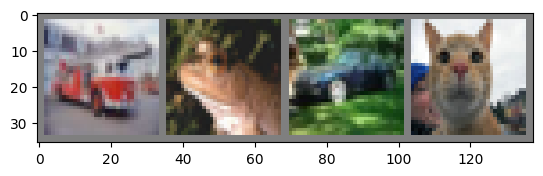

In [ ]:
#Visualizando algunas imágenes del conjunto de entrenamiento
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

image_iter = iter(train_loader)
images, _ = next(image_iter)
imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
#Seleccionando dispositivo para procesamiento
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#### Bloque básico y bloque de cuello de botella
<img src="https://raw.githubusercontent.com/blancavazquez/taller-linux/main/deep_learning/bottleneck.png" width="600px">



In [ ]:
class BasicBlock(nn.Module):
    """
    Construcción del bloque básico de la ResNet (usado en la arquitectura de 18 y 34 capas)
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
                                      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels))
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels))

    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
#Visualizando el bloque básico construido
basic_block = BasicBlock(64, 128)
print(basic_block)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [ ]:
x = torch.randn(2, 64, 32, 32)
y = basic_block(x)

print("Tamaño de x: ", x.shape)
print("Tamaño de y: ", y.shape)

Tamaño de x:  torch.Size([2, 64, 32, 32])
Tamaño de y:  torch.Size([2, 128, 32, 32])


In [ ]:
class Bottleneck(nn.Module):
    """
    Se construye el bloque básico (para redes con capas de 50,101 y 152 capas).
    """
    expansion = 4

    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
                                      nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
                                      nn.BatchNorm2d(zip_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                      nn.BatchNorm2d(zip_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
                                      nn.BatchNorm2d(out_channels)
                                      )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                                        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                                        nn.BatchNorm2d(out_channels)
                                        )

    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
#Visualizando el bloque básico construido
bottleneck = Bottleneck(256, 128)
print(bottleneck)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [ ]:
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)

print("Tamaño de x: ", x.shape)
print("Tamaño de y: ", y.shape)

Tamaño de x:  torch.Size([2, 256, 32, 32])
Tamaño de y:  torch.Size([2, 512, 32, 32])


#### Rendimiento de los modelos usando el bloque básico y cuello de botella

<img src="https://raw.githubusercontent.com/blancavazquez/taller-linux/main/deep_learning/performance.png" width="400px">

In [ ]:
class ResNet(nn.Module):
    """
    Se construye todas las capas que tendrá el modelo
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2]
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool]
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
                                      nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(inplace=True)
                                      )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [ ]:
#Se define los modelos de ResNet con diferentes números de capas
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [ ]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

print("Visualizando la arquitectura completa \n", net)

Visualizando la arquitectura completa 
 DataParallel(
  (module): ResNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (features): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (features): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [ ]:
#Haciendo algunas pruebas:
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print("Visualizando la salida", y.shape)

Visualizando la salida torch.Size([2, 10])


In [ ]:
#Definición de parámetros de la red
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

### Entrenamiento de la red

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*correct/total, correct, total))
    return train_loss

In [ ]:
load_model = False
if load_model:
    #Posterior al entrenamiento
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [ ]:
#Visualizando el rendimiento del modelo en cada época
for epoch in range(start_epoch, 10):
    loss = train(epoch)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss, epoch=epoch)


Epoch: 0
[1,   100] loss: 229.265490 |  Acc: 21.000% (2688/12800)
[1,   200] loss: 408.172958 |  Acc: 27.273% (6982/25600)
[1,   300] loss: 570.969744 |  Acc: 31.529% (12107/38400)
Total loss: 706.530322

Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1006: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[2,   100] loss: 141.711710 |  Acc: 47.930% (6135/12800)
[2,   200] loss: 271.146772 |  Acc: 50.398% (12902/25600)
[2,   300] loss: 391.900727 |  Acc: 52.307% (20086/38400)
Total loss: 494.788481

Epoch: 2
[3,   100] loss: 104.992856 |  Acc: 62.562% (8008/12800)
[3,   200] loss: 206.375366 |  Acc: 63.043% (16139/25600)
[3,   300] loss: 302.982237 |  Acc: 63.880% (24530/38400)
Total loss: 386.401649

Epoch: 3
[4,   100] loss: 83.246717 |  Acc: 70.703% (9050/12800)
[4,   200] loss: 165.965854 |  Acc: 70.621% (18079/25600)
[4,   300] loss: 246.316395 |  Acc: 70.977% (27255/38400)
Total loss: 317.427469

Epoch: 4
[5,   100] loss: 71.405390 |  Acc: 74.883% (9585/12800)
[5,   200] loss: 142.383738 |  Acc: 74.785% (19145/25600)
[5,   300] loss: 211.486818 |  Acc: 75.003% (28801/38400)
Total loss: 272.855694

Epoch: 5
[6,   100] loss: 57.634848 |  Acc: 79.617% (10191/12800)
[6,   200] loss: 118.361582 |  Acc: 79.312% (20304/25600)
[6,   300] loss: 176.727246 |  Acc: 79.422% (30498/38400)
Total

In [ ]:
#Guardando los resultados del modelo
save_model = True
if save_model:
    state = {
        'net': net.state_dict(),
        'epoch': epoch,}
    os.makedirs('checkpoint', exist_ok=True)
    torch.save(state, './checkpoint/res18.ckpt')

### Validación en el conjunto de prueba

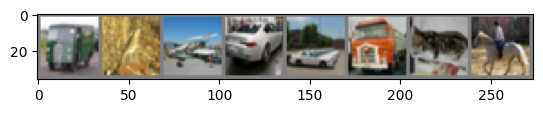

Real (GroundTruth):  truck  bird plane   car   car truck   cat horse
Predicción:  truck  bird plane   car   car truck   cat horse
Accuracy de la red en el conjunto de prueba (10000 imágenes): 81 %
Accuracy de plane : 93 %
Accuracy de   car : 92 %
Accuracy de  bird : 75 %
Accuracy de   cat : 60 %
Accuracy de  deer : 91 %
Accuracy de   dog : 76 %
Accuracy de  frog : 78 %
Accuracy de horse : 83 %


In [ ]:
#Iterando en el conjunto de prueba
samples = 8

dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:samples]
labels = labels[:samples]

# print images
imshow(torchvision.utils.make_grid(images))
print('Real (GroundTruth): ', ' '.join('%5s' % classes[labels[j]] for j in range(samples)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicción: ', ' '.join('%5s' % classes[predicted[j]] for j in range(samples)))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy de la red en el conjunto de prueba (10000 imágenes): %d %%' % (100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(samples):
    print('Accuracy de %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

## Usando un modelo ResNET pre-entrenado

Arquitecturas propuestas por ResNet

<img src="https://raw.githubusercontent.com/blancavazquez/taller-linux/main/deep_learning/Arquitecturas.png" width="600px">


In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Descargando un ejemplo del sitio de pytorch
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)

#Preprocesamiento de la imagen
preprocess = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # creación de un mini-lote

# Moviendo la imagen de entrada y el modelo hacia GPU para acelerar
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Tensor de tamaño 1000 con la predicción de las clases de ImageNet
print(output[0])
# La salida no está normalizada. Para conseguir las probabilidades se aplica softmax.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([ 1.5917e-02, -1.5497e+00,  3.2031e-01, -2.0585e+00, -8.5747e-01,
         1.7843e+00,  1.4699e+00,  2.1626e+00,  4.4888e+00,  8.2885e-01,
        -5.7819e+00, -3.4969e+00, -4.0621e+00, -4.7517e+00, -3.8072e+00,
        -4.7243e+00, -1.2590e+00,  2.9813e-01, -2.0459e+00, -5.2885e-01,
        -3.5982e+00, -8.1425e-01, -2.7651e+00, -1.2770e+00, -3.4182e+00,
        -1.9048e+00, -3.0018e+00, -1.3471e+00, -1.8391e+00,  1.3937e+00,
        -2.0114e+00, -1.4137e+00, -2.3287e+00, -1.8198e+00, -1.1914e-01,
        -3.4102e+00, -1.6544e+00, -3.4496e+00, -2.6479e+00, -2.7407e+00,
        -2.2193e+00, -3.6509e+00, -4.1255e+00, -5.5946e+00, -1.7519e+00,
        -1.6900e+00, -9.8164e-01, -2.1251e+00, -3.5137e+00, -1.3320e+00,
        -1.1335e+00, -1.1564e+00, -2.2712e-02, -8.5797e-01, -1.2919e+00,
        -2.8682e+00,  6.6078e-01, -1.7178e+00, -1.2443e+00, -2.3362e+00,
        -5.7819e-02, -1.9204e+00, -2.5964e+00, -1.8020e+00, -1.5125e+00,
        -1.0843e+00, -4.0987e-01, -1.3090e+00, -9.4

In [ ]:
# Descargando las etiquetas de ImageNet
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-03-06 10:03:59--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-03-06 10:03:59 (57.3 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
# Leyendo las clases
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Mostrando el top-5 de clases por imagen
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.8846217393875122
Arctic fox 0.04580526798963547
white wolf 0.04427628964185715
Pomeranian 0.005621335469186306
Great Pyrenees 0.004652000498026609


## Referencias

[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)